# オルツ 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '260A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-27 00:00:00+09:00,605.0,613.0,575.0,579.0,1135200,0.0,0.0
2025-02-28 00:00:00+09:00,565.0,583.0,556.0,578.0,1055600,0.0,0.0
2025-03-03 00:00:00+09:00,595.0,598.0,581.0,591.0,602600,0.0,0.0
2025-03-04 00:00:00+09:00,577.0,580.0,558.0,570.0,656000,0.0,0.0
2025-03-05 00:00:00+09:00,568.0,574.0,553.0,559.0,611700,0.0,0.0


## 日足チャートとパラボリック SAR

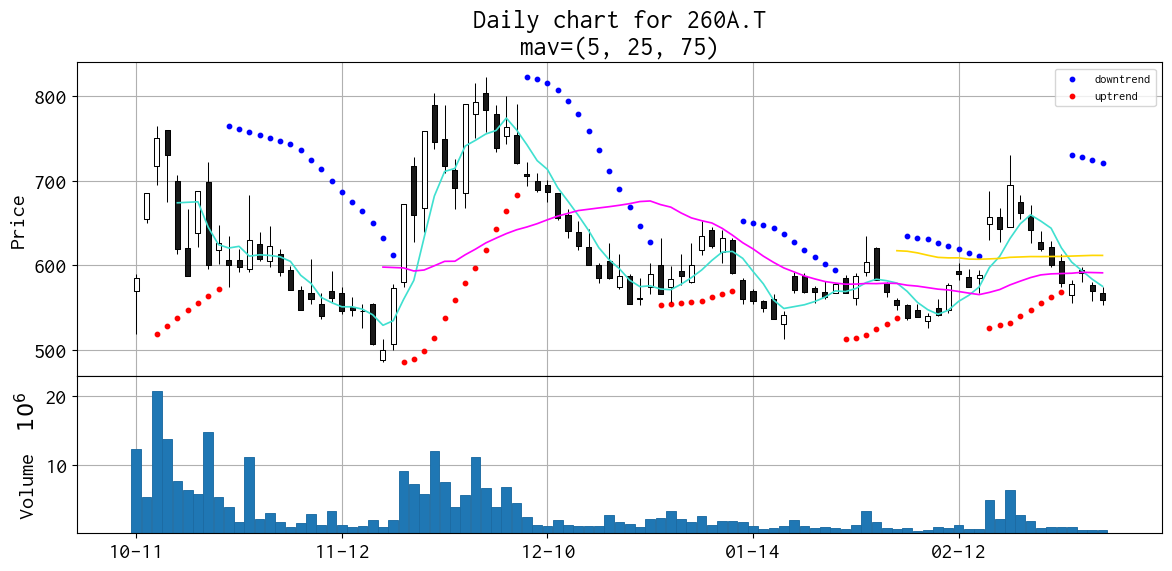

In [3]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best', fontsize=9)


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-05 00:00:00+09:00,568.0,574.0,562.0,568.0,85200,0.0,0.0


In [5]:
df.tail(2)['Close']

Date
2025-03-04 00:00:00+09:00    570.0
2025-03-05 00:00:00+09:00    568.0
Name: Close, dtype: float64

In [6]:
df.tail(2)['Close'].diff()

Date
2025-03-04 00:00:00+09:00    NaN
2025-03-05 00:00:00+09:00   -2.0
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-03-04 00:00:00+09:00    583.8
2025-03-05 00:00:00+09:00    577.2
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-03-04 00:00:00+09:00    591.64
2025-03-05 00:00:00+09:00    591.68
Name: Close, dtype: float64